# 04_ NSGA_RWNN 모듈화  => 이후 multi-gpu 최적화 진행해야함


- 기존 nn.DataParallel(RWNN) 만 하니까, GPU 사용률이 30~70퍼 정도를 왔다갔다함.

[Reference] https://pytorch.org/tutorials/intermediate/ddp_tutorial.html

# Main

In [1]:
import os
import logging
from easydict import EasyDict
import numpy as np
import random

import time
import datetime

from deap import tools

In [2]:
from utils_kyy.utils_graph import make_random_graph
from utils_kyy.create_toolbox import create_toolbox_for_NSGA_RWNN

## 1. generation pool 구성하기 (Small RWNN 대상)

In [3]:
# 실험을 위한 환경 셋팅
run_code = 'test_kyy_module'
stage_pool_path = './graph_pool' + '/' + run_code + '/'
log_path = './logs/' + run_code + '/'

# check & make the directory
if not os.path.exists(stage_pool_path): os.makedirs(stage_pool_path)
if not os.path.isdir(log_path): os.makedirs(log_path)
    
# write the log
logging.basicConfig(filename=log_path + 'logging.log', level=logging.INFO)
logging.info('Start to write log.')

In [4]:
# make random graph pool
num_graph = 100
make_random_graph(num_graph, stage_pool_path)

######################################################
# => 최종적으로, num_graph와 stage_pool_path 를 인수로 받아서, 해당 path에 num_graph 수 만큼의 그래프 떨궈주는 함수 만들기
#    일단은 정해진 graph_model은 'WS', K, P 는 인수로 받지 말고 구현
#      =>  이후에 확장하기.
######################################################

Start to make random graph pool...
Finished


## 2. Main NSGA_RWNN

In [5]:
# define 'args_train' for evaluation
args_train = EasyDict({
    'lr_mode': 'cosine',
    'warmup_mode': 'linear',    # default
    'base_lr': 0.1,
    'momentum': 0.9, 
    'weight_decay': 0.00005,
    'print_freq': 100,

    'epochs': 2,
    'batch_size': 256,   # 128 => 256

    'workers': 32,  # 2 => 

    'warmup_epochs': 0,
    'warmup_lr': 0.0,
    'targetlr': 0.0,

})

In [6]:
# create custom_toolbox
# num_graph, args_train, stage_pool_path => to define the 'evaluate' function 
toolbox = create_toolbox_for_NSGA_RWNN(num_graph, args_train, stage_pool_path)

In [ ]:
"""
4. Algorithms
 For the purpose of completeness we will develop the complete generational algorithm.
"""

POP_SIZE = 8    # population size
NGEN = 10    # number of Generation
CXPB = 0.5    # crossover probability 
MUTPB = 0.5    # mutation probability


# log에 기록할 stats
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "min", "max", "evals_time", "gen_time"

# population 생성.  (toolbox.population은 creator.Individual n개를 담은 list를 반환. (=> population)
now = datetime.datetime.now()
now_str = now.strftime('%Y-%m-%d %H:%M:%S')
print("Initialion starts ...")
logging.info("Initialion starts at " + now_str)
init_start_time = time.time()

pop = toolbox.population(n=POP_SIZE)

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)    # .evaluate는 tuple을 반환. 따라서 fitnesses는 튜플을 원소로 가지는 list
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit   # ind.fitness.values = (val_accuracy, flops) 튜플

# This is just to assign the crowding distance to the individuals
# no actual selection is done
pop = toolbox.select(pop, len(pop))

record = stats.compile(pop)
logbook.record(gen=0, evals=len(invalid_ind), **record)
print(logbook.stream)

now = datetime.datetime.now()
now_str = now.strftime('%Y-%m-%d %H:%M:%S')
print("Initialization is finished at", now_str)
logging.info("Initialion is finished at " + now_str)

init_time = time.time() - init_start_time
logging.info("Initialion time = " + str(init_time) + "s")


print()

# Begin the generational process
for gen in range(1, NGEN):
    now = datetime.datetime.now()
    now_str = now.strftime('%Y-%m-%d %H:%M:%S')
    print("#####", gen, "th generation starts at", now_str)
    logging.info(str(gen) + "th generation starts at" + now_str)
    
    start_gen = time.time()
    # Vary the population
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if random.random() <= CXPB:
            toolbox.mate(ind1, ind2)

        toolbox.mutate(ind1, indpb=MUTPB)
        toolbox.mutate(ind2, indpb=MUTPB)
        del ind1.fitness.values, ind2.fitness.values

    # Evaluate the individuals with an invalid fitness
    print("##### Evaluation starts")
    start_time = time.time()
    
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    eval_time_for_one_generation = time.time() - start_time        
    print("##### Evaluation ends (Time : %.3f)" % eval_time_for_one_generation)
    
    # Select the next generation population
    pop = toolbox.select(pop + offspring, POP_SIZE)
    
    gen_time = time.time() - start_gen
    print('##### [gen_time: %.3fs]' % gen_time, gen, 'th generation is finished.')
    
    record = stats.compile(pop)
    logbook.record(gen=gen, evals=len(invalid_ind), **record,
                   evals_time=eval_time_for_one_generation, gen_time=gen_time)
    
    logging.info('Gen [%03d/%03d] -- evals: %03d, evals_time: %.4fs, gen_time: %.4fs' % (gen, NGEN, len(invalid_ind), eval_time_for_one_generation, gen_time))
    print(logbook.stream)

Initialion starts ...
	 - Epoch: [0][0/196]	Time 14.699 (14.699)	Loss 7.0175 (7.0175)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)
	 - Epoch: [0][100/196]	Time 0.559 (0.725)	Loss 1.6201 (1.9692)	Prec@1 41.406 (30.871)	Prec@5 90.234 (81.946)
Validation_time 14.767 Prec@1 43.760 Prec@5 91.240
	 - Epoch: [1][0/196]	Time 7.812 (7.812)	Loss 1.4326 (1.4326)	Prec@1 47.266 (47.266)	Prec@5 93.750 (93.750)
	 - Epoch: [1][100/196]	Time 0.614 (0.662)	Loss 1.1036 (1.2394)	Prec@1 60.938 (55.190)	Prec@5 94.922 (94.833)
Validation_time 14.345 Prec@1 61.010 Prec@5 96.350
	 - Epoch: [0][0/196]	Time 8.393 (8.393)	Loss 6.8680 (6.8680)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)
	 - Epoch: [0][100/196]	Time 0.635 (0.714)	Loss 1.7573 (2.0802)	Prec@1 33.203 (27.750)	Prec@5 86.328 (78.899)
Validation_time 15.128 Prec@1 44.220 Prec@5 91.900
	 - Epoch: [1][0/196]	Time 6.939 (6.939)	Loss 1.5746 (1.5746)	Prec@1 41.797 (41.797)	Prec@5 89.844 (89.844)
	 - Epoch: [1][100/196]	Time 0.618 (0.701)	Loss 1.2626 (1.3715)	Prec@

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python

	 - Epoch: [0][0/196]	Time 6.618 (6.618)	Loss 6.9369 (6.9369)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)
	 - Epoch: [0][100/196]	Time 0.657 (0.711)	Loss 1.5242 (1.9415)	Prec@1 42.188 (31.973)	Prec@5 91.797 (83.087)
Validation_time 15.933 Prec@1 49.490 Prec@5 93.830
	 - Epoch: [1][0/196]	Time 6.885 (6.885)	Loss 1.3132 (1.3132)	Prec@1 50.000 (50.000)	Prec@5 96.094 (96.094)
	 - Epoch: [1][100/196]	Time 0.647 (0.716)	Loss 1.3213 (1.1743)	Prec@1 53.125 (57.797)	Prec@5 93.750 (95.494)
Validation_time 15.793 Prec@1 62.970 Prec@5 96.620
	 - Epoch: [0][0/196]	Time 7.269 (7.269)	Loss 6.8912 (6.8912)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)
	 - Epoch: [0][100/196]	Time 0.902 (0.976)	Loss 1.8350 (2.0809)	Prec@1 30.469 (27.634)	Prec@5 81.641 (78.419)
Validation_time 19.417 Prec@1 39.490 Prec@5 89.890
	 - Epoch: [1][0/196]	Time 7.174 (7.174)	Loss 1.5667 (1.5667)	Prec@1 41.016 (41.016)	Prec@5 88.672 (88.672)
	 - Epoch: [1][100/196]	Time 0.894 (0.975)	Loss 1.3427 (1.4510)	Prec@1 48.438 (46.442)	Prec@5

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python

	 - Epoch: [0][0/196]	Time 5.246 (5.246)	Loss 6.9441 (6.9441)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)
	 - Epoch: [0][100/196]	Time 0.557 (0.564)	Loss 1.6109 (1.9857)	Prec@1 39.453 (30.438)	Prec@5 89.844 (81.962)
Validation_time 13.666 Prec@1 50.400 Prec@5 94.210
	 - Epoch: [1][0/196]	Time 6.881 (6.881)	Loss 1.2025 (1.2025)	Prec@1 55.859 (55.859)	Prec@5 96.094 (96.094)
	 - Epoch: [1][100/196]	Time 0.505 (0.566)	Loss 0.9451 (1.1774)	Prec@1 66.797 (57.553)	Prec@5 96.875 (95.220)
Validation_time 13.543 Prec@1 65.230 Prec@5 96.760
	 - Epoch: [0][0/196]	Time 6.278 (6.278)	Loss 6.8723 (6.8723)	Prec@1 0.000 (0.000)	Prec@5 3.516 (3.516)
	 - Epoch: [0][100/196]	Time 0.439 (0.508)	Loss 1.6377 (2.0317)	Prec@1 39.062 (29.107)	Prec@5 88.672 (80.825)
Validation_time 12.667 Prec@1 43.210 Prec@5 92.350
	 - Epoch: [1][0/196]	Time 6.038 (6.038)	Loss 1.4892 (1.4892)	Prec@1 42.969 (42.969)	Prec@5 93.359 (93.359)
	 - Epoch: [1][100/196]	Time 0.450 (0.511)	Loss 1.3088 (1.3331)	Prec@1 53.906 (51.207)	Prec@5

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.5/logging/__init__.py", line 980, in emit
    msg = self.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 830, in format
    return fmt.format(record)
  File "/usr/lib/python3.5/logging/__init__.py", line 567, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.5/logging/__init__.py", line 330, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python

	 - Epoch: [0][0/196]	Time 7.072 (7.072)	Loss 6.9270 (6.9270)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)
	 - Epoch: [0][100/196]	Time 0.831 (0.904)	Loss 1.6655 (2.0109)	Prec@1 39.453 (29.974)	Prec@5 89.844 (80.461)
Validation_time 18.288 Prec@1 43.920 Prec@5 92.290
	 - Epoch: [1][0/196]	Time 6.976 (6.976)	Loss 1.3937 (1.3937)	Prec@1 48.438 (48.438)	Prec@5 94.141 (94.141)
	 - Epoch: [1][100/196]	Time 0.825 (0.905)	Loss 1.1953 (1.3282)	Prec@1 57.422 (51.779)	Prec@5 94.141 (93.560)
Validation_time 18.386 Prec@1 59.240 Prec@5 95.760
	 - Epoch: [0][0/196]	Time 6.751 (6.751)	Loss 6.9071 (6.9071)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)
	 - Epoch: [0][100/196]	Time 0.539 (0.626)	Loss 1.6264 (1.9632)	Prec@1 39.062 (31.467)	Prec@5 88.672 (82.406)
Validation_time 14.329 Prec@1 48.260 Prec@5 92.530
	 - Epoch: [1][0/196]	Time 6.921 (6.921)	Loss 1.3816 (1.3816)	Prec@1 49.609 (49.609)	Prec@5 93.359 (93.359)
	 - Epoch: [1][100/196]	Time 0.581 (0.622)	Loss 1.2318 (1.2563)	Prec@1 55.859 (54.753)	Prec@5

In [8]:
# Check logbook
logbook

[{'evals': 8,
  'gen': 0,
  'max': array([-5.69600000e+01,  2.14100378e+09]),
  'min': array([-6.2300000e+01,  1.5689408e+09])},
 {'evals': 8,
  'evals_time': 2940.775217294693,
  'gen': 1,
  'gen_time': 2940.7760870456696,
  'max': array([-5.87500000e+01,  2.05443725e+09]),
  'min': array([-6.2970000e+01,  1.5689408e+09])},
 {'evals': 8,
  'evals_time': 2238.9005932807922,
  'gen': 2,
  'gen_time': 2238.901383161545,
  'max': array([-5.61600000e+01,  1.80627277e+09]),
  'min': array([-6.52300000e+01,  1.35696742e+09])},
 {'evals': 8,
  'evals_time': 2318.383440732956,
  'gen': 3,
  'gen_time': 2318.3843405246735,
  'max': array([-5.85100000e+01,  1.79992755e+09]),
  'min': array([-6.52300000e+01,  1.35696742e+09])},
 {'evals': 8,
  'evals_time': 2142.6277430057526,
  'gen': 4,
  'gen_time': 2142.6286928653717,
  'max': array([-5.8510000e+01,  1.7974921e+09]),
  'min': array([-6.52300000e+01,  1.34000448e+09])},
 {'evals': 8,
  'evals_time': 2459.421911239624,
  'gen': 5,
  'gen_time':

### logbook - plot

In [11]:
type(logbook)

deap.tools.support.Logbook

In [13]:
len(logbook)

10

In [15]:
logbook[0]

{'evals': 8,
 'gen': 0,
 'max': array([-5.69600000e+01,  2.14100378e+09]),
 'min': array([-6.2300000e+01,  1.5689408e+09])}

In [17]:
logbook[0]['min']

array([-6.2300000e+01,  1.5689408e+09])

In [20]:
-logbook[0]['min'][0], logbook[0]['min'][1]

(62.3, 1568940800.0)

In [23]:
min_val_acc = []
min_flops = []

max_val_acc = []
max_flops = []

for i in range(len(logbook)):
    min_val_acc_i, min_flops_i = -logbook[i]['min'][0], logbook[i]['min'][1]
    max_val_acc_i, max_flops_i = -logbook[i]['max'][0], logbook[i]['max'][1]
    
    min_val_acc.append(min_val_acc_i)
    min_flops.append(min_flops_i)
    max_val_acc.append(max_val_acc_i)
    max_flops.append(max_flops_i)    

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

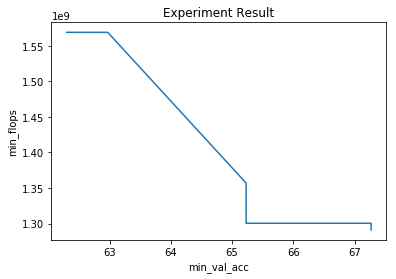

In [26]:
# NSGA-2가 제대로 동작함을 알 수 있음.
plt.plot(min_val_acc, min_flops)

plt.xlabel('min_val_acc')
plt.ylabel('min_flops')
plt.title('Experiment Result')

plt.show()

In [33]:
# gen time 확인
gen_time_list = []

for i in range(1, len(logbook)):
    # 첫번째 initialize 에는 gen_time이 없음
    gen_time_i = logbook[i]['gen_time']
    gen_time_list.append(gen_time_i)

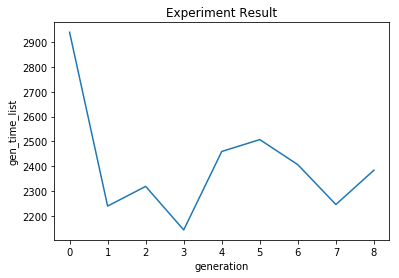

In [35]:
plt.plot(gen_time_list)

plt.xlabel('generation')
plt.ylabel('gen_time_list')
plt.title('Experiment Result')

plt.show()